In [1]:
def trim_borders(array, top=0, bottom=0, left=0, right=0):
    if len(array.shape) != 2:
        raise ValueError("Input array must be 2D")

    return array[top : array.shape[0] - bottom, left : array.shape[1] - right]


Loaded 0 files
Loaded 50 files
Loaded 100 files
Loaded 150 files
Loaded 200 files
Loaded 250 files
Loaded 300 files
Loaded 350 files
Loaded 400 files
Data shape: (423, 320, 320)
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 645ms/step - loss: 0.2495 - val_loss: 0.2434
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - loss: 0.2347 - val_loss: 0.2254
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step - loss: 0.2233 - val_loss: 0.2216
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step - loss: 0.2207 - val_loss: 0.2204
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 514ms/step - loss: 0.2197 - val_loss: 0.2195
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - loss: 0.2188 - val_loss: 0.2187
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 516ms/step - loss: 0.2179 - val_loss: 0.2182
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - loss: 0.2175 - val_loss: 0.2178
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - loss: 0.2171 - val_loss: 0.2177
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms

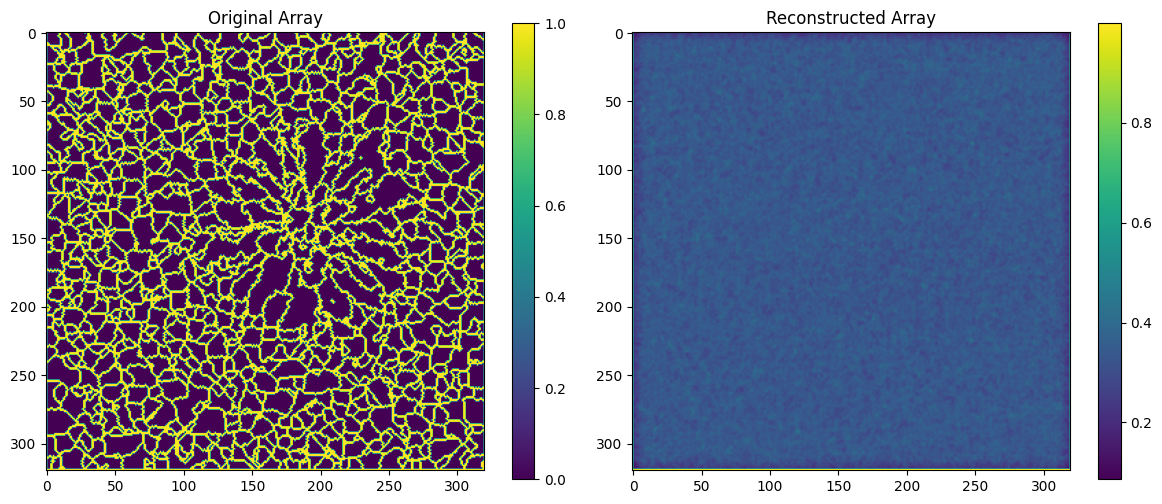

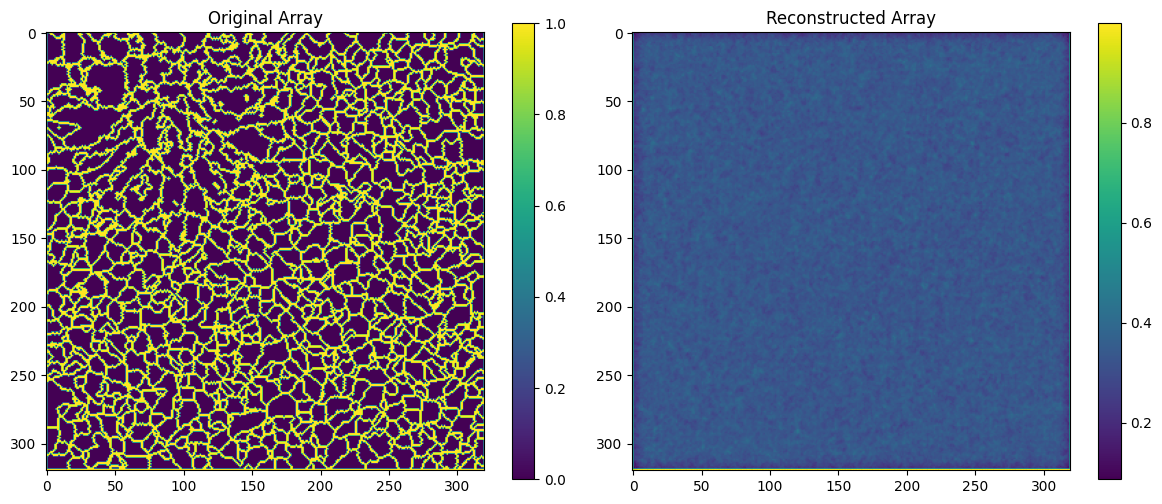

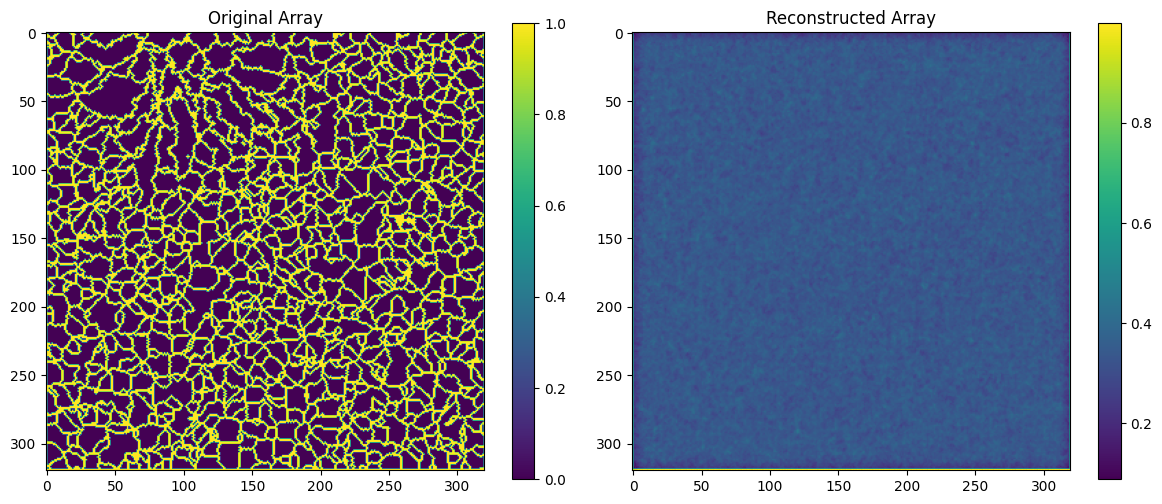

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023B0CC44E00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Encoded data shape: (85, 64)
Sample encoded vector: [ 3.592572   13.83661     0.         17.646177    6.0272455   0.
  7.6204343   0.          0.          1.5283836   0.24310677  0.
  0.          0.

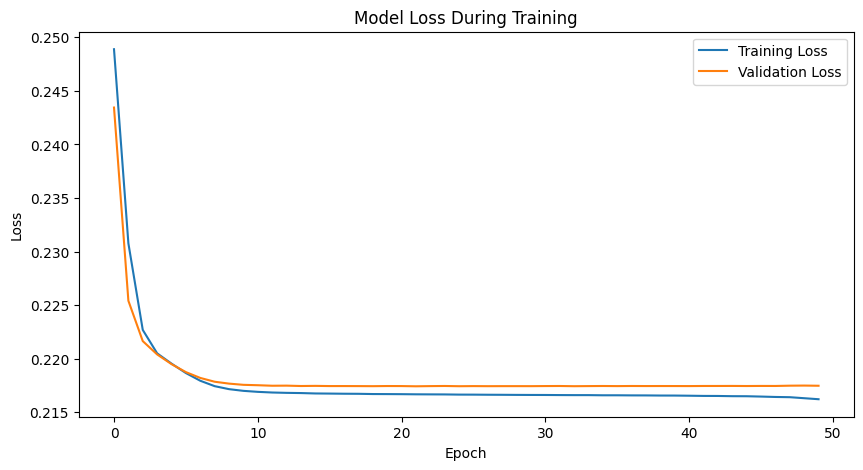

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Function to load and preprocess data
def load_data(directory):
    data = []
    i = 0
    for filename in os.listdir(directory):
        # if(i==60):
        #     continue
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, header=None)
            data.append(trim_borders(df.values, top=1, bottom=1, left=1, right=1))
            if i % 50 == 0:
                print(f"Loaded {i} files")
            i += 1
    return np.array(data)


# Load data
data = load_data("../output")

print("Data shape:", data.shape)

# Reshape for conv2d layers (adding channel dimension)
data = data.reshape((-1, 320, 320, 1))

# Split data into training and testing sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Define the autoencoder model
input_shape = (320, 320, 1)
encoding_dim = 64  # Size of the encoded representation

encoder = models.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(8, (3, 3), activation="relu", padding="same", strides=2),
        layers.Conv2D(16, (3, 3), activation="relu", padding="same", strides=2),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", strides=2),
        layers.Flatten(),
        layers.Dense(encoding_dim, activation="relu"),
    ]
)

decoder = models.Sequential(
    [
        layers.Input(shape=(encoding_dim,)),
        layers.Dense(40 * 40 * 128, activation="relu"),
        layers.Reshape((40, 40, 128)),
        layers.Conv2DTranspose(
            32, (3, 3), strides=2, activation="relu", padding="same"
        ),
        layers.Conv2DTranspose(
            16, (3, 3), strides=2, activation="relu", padding="same"
        ),
        layers.Conv2DTranspose(
            1, (3, 3), strides=2, activation="sigmoid", padding="same"
        ),
    ]
)

autoencoder = models.Sequential([encoder, decoder])

# Compile the model
autoencoder.compile(optimizer="adam", loss="mse")

# Train the model
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
)

# Evaluate the model
test_loss = autoencoder.evaluate(X_test, X_test)
print(f"Test loss: {test_loss}")


# Function to visualize original vs reconstructed arrays
def visualize_reconstruction(original, reconstructed, index):
    original_2d = original[index].reshape(data.shape[1], data.shape[2])
    reconstructed_2d = reconstructed[index].reshape(data.shape[1], data.shape[2])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    im1 = ax1.imshow(original_2d, cmap="viridis")
    ax1.set_title("Original Array")
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(reconstructed_2d, cmap="viridis")
    ax2.set_title("Reconstructed Array")
    fig.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()


# Reconstruct test data
reconstructed = autoencoder.predict(X_test)

# Visualize a few examples
for i in range(3):
    visualize_reconstruction(X_test, reconstructed, i)

# Encode data to analyze latent space
encoded_data = encoder.predict(X_test)
print("Encoded data shape:", encoded_data.shape)
print("Sample encoded vector:", encoded_data[0])

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()